In [20]:
import os
import random
import math
import h5py
import concurrent.futures
import matplotlib.pyplot as plt
font = {'size'   : 5}
plt.rc('font', **font)

import numpy as np
import pandas as pd
import pandas.api.types
from tqdm import tqdm
from glob import glob
from PIL import Image
import cv2
from io import BytesIO

import torch
from torch import nn
import torch.nn.functional as F
import lightning as L

import albumentations as albu
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, KFold, StratifiedGroupKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler


import timm
import wandb

In [21]:
wandb.login()

True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

print('Using device:', device)

Using device: cuda


In [22]:
default_config= {
 'VERSION': 'v1.6.1',
 'DESCRIPTION': 'Stage 2 24 data',
 'DATA_PATH': 'isic-2024-challenge',
 
 #-------Global-------#
 'IMAGE_SIZE': 300,
 'SEED': 24,
 #################################################
 
 #-------Image Augmentation-------#

 #################################################

 #-------Training hyperparameter-------#
 'BACKBONE': "tf_efficientnet_b3.in1k", # [ "eca_nfnet_l0" 256,"tf_efficientnet_b0.in1k" 256; "tf_efficientnetv2_s.in21k" 300;  "seresnext26t_32x4d.bt_in1k" 224; "tf_efficientnet_b3.ns_jft_in1k" 300; "resnet34.a1_in1k" 224; "efficientnet_b3.ra2_in1k" 288; "resnet50.a1_in1k" 224; "eca_nfnet_l0.ra2_in1k" 224]
 'EPOCHS': 10,
 'FOLD': 5,
 'BACTHSIZE': 64,
 'LOSS': 'BCE'
 #################################################
}

In [23]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(default_config['SEED'])

In [24]:
class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:
    '''
    2024 ISIC Challenge metric: pAUC
    
    Given a solution file and submission file, this function returns the
    the partial area under the receiver operating characteristic (pAUC) 
    above a given true positive rate (TPR) = 0.80.
    https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.
    
    (c) 2024 Nicholas R Kurtansky, MSKCC

    Args:
        solution: ground truth pd.DataFrame of 1s and 0s
        submission: solution dataframe of predictions of scores ranging [0, 1]

    Returns:
        Float value range [0, max_fpr]
    '''

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    # check submission is numeric
    if not pandas.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('Submission target column must be numeric')

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(solution.values)-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0*np.asarray(submission.values)

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

#     # Equivalent code that uses sklearn's roc_auc_score
#     v_gt = abs(np.asarray(solution.values)-1)
#     v_pred = np.array([1.0 - x for x in submission.values])
#     max_fpr = abs(1-min_tpr)
#     partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
#     # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
#     # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
#     partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return(partial_auc)

# 1. Dataset

In [25]:
df_data_full = pd.read_csv(f"{default_config['DATA_PATH']}/train-metadata.csv")
# df_data = df_data.drop(df_data[df_data['target'] == 0].sample(frac=.995).index).reset_index(drop=True)

df_positive = df_data_full[df_data_full["target"] == 1].reset_index(drop=True)
df_negative = df_data_full[df_data_full["target"] == 0].reset_index(drop=True)

df_data = pd.DataFrame()
for index, row in df_positive.iterrows():
    tmp = df_negative.loc[df_negative['patient_id']==row['patient_id']].reset_index(drop=True)
    tmp = pd.concat([tmp, df_data]).drop_duplicates(keep=False)
    df_data = pd.concat([df_data, tmp.reset_index(drop=True).sample(n=20)])
# df_data = pd.concat([df_positive, df_negative.iloc[:df_positive.shape[0]*20, :]]).reset_index(drop=True)  # positive:negative = 1:20

hdf5_file = h5py.File(f"{default_config['DATA_PATH']}/train-image.hdf5", mode="r")

df_data = pd.concat([df_data, df_positive])[['isic_id', 'patient_id', 'target']].reset_index(drop=True)
df_data

C:\Users\hoang\AppData\Local\Temp\ipykernel_18628\308967938.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data_full = pd.read_csv(f"{default_config['DATA_PATH']}/train-metadata.csv")


,isic_id,patient_id,target
0,ISIC_7355786,IP_3249371,0
1,ISIC_3888335,IP_3249371,0
2,ISIC_7653071,IP_3249371,0
3,ISIC_1807866,IP_3249371,0
4,ISIC_2812243,IP_3249371,0
...,...,...,...
8248,ISIC_9877311,IP_4717387,1
8249,ISIC_9941636,IP_7607582,1
8250,ISIC_9972649,IP_9181133,1
8251,ISIC_9972877,IP_8877928,1


In [8]:
# for y in [18,19,20]:
#     df_data_ = pd.read_csv(f"isic-2024-challenge/ISIC20{y}/train-metadata.csv")
#     df_positive = df_data_[df_data_["target"] == 1].reset_index(drop=True)
#     df_negative = df_data_[df_data_["target"] == 0].reset_index(drop=True)

#     df_data_ = pd.concat([df_positive, df_negative.iloc[:df_positive.shape[0]*20, :]])  # positive:negative = 1:20

#     df_data = pd.concat([df_data, df_data_])

# df_data = df_data[['isic_id', 'patient_id', 'target']].reset_index(drop=True)
# df_data

In [9]:
from albumentations.core.transforms_interface import ImageOnlyTransform


class AdvancedHairAugmentation(ImageOnlyTransform):
    def __init__(self, hairs: int = 4, hairs_folder: str = "", always_apply=False, p=0.5):
        super(AdvancedHairAugmentation, self).__init__(always_apply=always_apply, p=p)
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def apply(self, image, **params):
        n_hairs = random.randint(0, self.hairs)

        if not n_hairs:
            return image

        height, width, _ = image.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]

        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.cvtColor(hair, cv2.COLOR_BGR2RGB)
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, image.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, image.shape[1] - hair.shape[1])
            roi = image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            dst = cv2.add(img_bg, hair_fg)
            image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
        return image

    def get_params_dependent_on_targets(self, params):
        return {}

    @property
    def targets_as_params(self):
        return ["image"]

    def get_transform_init_args_names(self):
        return ()

In [26]:
train_transform = albu.Compose([
        albu.Transpose(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.HorizontalFlip(p=0.5),
        albu.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.75),
        albu.OneOf([
            albu.MotionBlur(blur_limit=5),
            albu.MedianBlur(blur_limit=5),
            albu.GaussianBlur(blur_limit=5),
            albu.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.7),
        albu.OneOf([
            albu.OpticalDistortion(distort_limit=1.0),
            albu.GridDistortion(num_steps=5, distort_limit=1.),
            albu.ElasticTransform(alpha=3),
        ], p=0.7),
        albu.CLAHE(clip_limit=4.0, p=0.7),
        albu.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),

        albu.Resize(height=default_config['IMAGE_SIZE'], width=default_config['IMAGE_SIZE']),

        albu.CoarseDropout(max_height=int(default_config['IMAGE_SIZE'] * 0.0375), max_width=int(default_config['IMAGE_SIZE'] * 0.0375), p=0.7),
        
        albu.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2(p=1.0)])

valid_transform = albu.Compose([
        albu.Resize(height=default_config['IMAGE_SIZE'], width=default_config['IMAGE_SIZE']),
        albu.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2(p=1.0)])

C:\Users\hoang\AppData\Roaming\Python\Python39\site-packages\pydantic\main.py:176: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)


In [36]:
class ISICDataset(torch.utils.data.Dataset):
    def __init__(self, hdf5_file, df_data, transform=None):
        self.df_data = df_data

        self.df_positive = df_data[df_data["target"] == 1].reset_index()
        self.df_negative = df_data[df_data["target"] == 0].reset_index()

        self.transform = transform
        self.fp_hdf = hdf5_file
    
    def __len__(self):
        return len(self.df_data)
    
    def __getitem__(self, index):
        if random.random() >=0.5:
            df = self.df_positive
        else:
            df = self.df_negative
        
        index = index % df.shape[0]
        sample_row = self.df_data.iloc[index]

        try:
            image = np.array(Image.open(BytesIO(self.fp_hdf[sample_row['isic_id']][()])))
        except:
            try:
                image = np.array(Image.open(f"isic-2024-challenge/ISIC2018/train-image/image/{sample_row['isic_id']}.jpg"))
            except:
                try:
                    image = np.array(Image.open(f"isic-2024-challenge/ISIC2019/train-image/image/{sample_row['isic_id']}.jpg"))
                except:
                    image = np.array(Image.open(f"isic-2024-challenge/ISIC2020/train-image/image/{sample_row['isic_id']}.jpg"))

        if self.transform!=None:
             image = self.transform(image=image)['image']
        y = sample_row['target']
        
        return image, y

In [37]:
dataset = ISICDataset(hdf5_file=hdf5_file, df_data=df_data, transform=train_transform)
dataset[0][1]

0

## 1.1 Display one batch in Dataset

In [38]:
false_pos = pd.read_csv("False Positive Sample.csv")
false_neg = pd.read_csv("False Negative Sample.csv")

[ 8  2  8  4  0  2  1  8  4  4  7  5  9  8  7  3  2  8  1 10  6  4  5  2
  2  6  3  9 10  1  7  0  9  3  4  8  0  4  2  9  5  7  1  1  4  8  8  2
  0  3]


C:\Users\hoang\AppData\Local\Temp\ipykernel_18628\2690640726.py:20: RuntimeWarning: divide by zero encountered in scalar remainder
  index = index % df.shape[0]


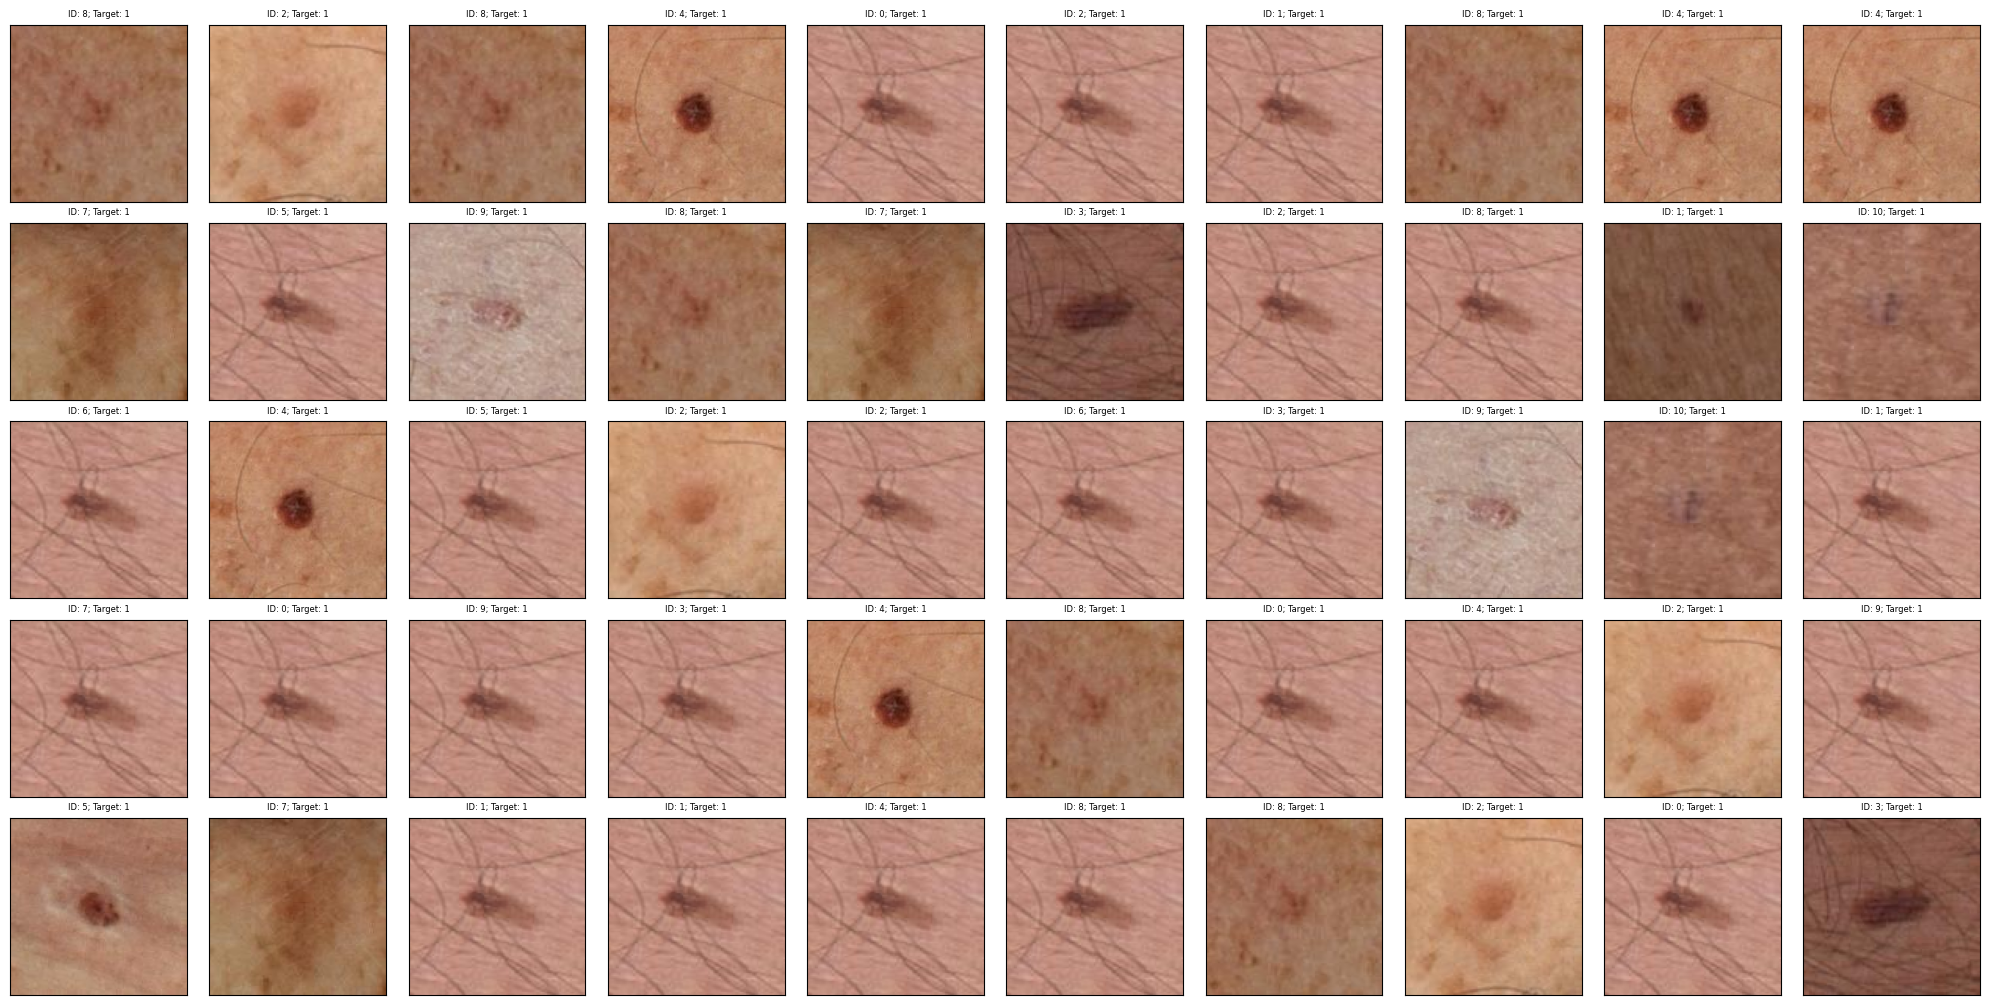

In [46]:
def display_batch(malignant_only=False):
    tmp_df = false_neg
    if malignant_only:
        tmp_df = df_data[df_data['target']==1]
    dataset = ISICDataset(hdf5_file=hdf5_file, df_data=tmp_df)
    fig = plt.figure(figsize=(20,10))
    
    img_index = np.random.randint(0, len(dataset)-1, 5*10)
    print(img_index)
    
    for i in range(len(img_index)):
        img, labels = dataset[img_index[i]]
        
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy() 
        
        ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
        # ax.imshow(np.transpose(img, (1,2,0)))
        ax.imshow(img)
        lbl = labels.item()
        ax.set_title(f'ID: {img_index[i]}; Target: {lbl}')

    plt.tight_layout()
    plt.show()


display_batch(malignant_only=False)

## 2. Model

In [14]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'
    
class ISICModel(nn.Module):
    def __init__(self, num_classes):
        super(ISICModel, self).__init__()

        self.backbone = timm.create_model(default_config['BACKBONE'], pretrained=True, num_classes=num_classes)

        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()

        self.globalpooling = GeM()
        self.dropout = nn.Dropout(p=0.3)
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, ximage):
        x = self.backbone(ximage)
        x = self.globalpooling(x).flatten(1)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [15]:
# model = ISICModel(num_classes=1).to(device)
# inputs = torch.randn(64, 3, 300, 300).to(device)

# with torch.autograd.profiler.profile(use_cuda=True) as prof:
#     outputs = model(inputs)

# print(prof.key_averages().table(sort_by="cuda_time_total"))

In [16]:
ssk = StratifiedGroupKFold(n_splits=default_config["FOLD"])
df_data['fold'] = 0
for fold, (train_idx, val_idx) in enumerate(ssk.split(df_data, df_data.target, df_data.patient_id)):
    df_data.loc[val_idx, 'fold'] = fold

In [17]:
if not os.path.exists(f"model/{default_config['VERSION']}"):
    os.makedirs(f"model/{default_config['VERSION']}")

# 3.Training loop

In [18]:
import gc
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [19]:
for f in range(default_config["FOLD"]):
    run = wandb.init(project="ISIC2024", name=f"Model_Fold{f}_{default_config['VERSION']}", entity="lhklevi", config=default_config)
    wandb.alert(title=f"Start Model_Fold {f} !!!", text=f"Start Model_Fold {f} !!!")
    # main loop of f-fold
    print('=================================================================================================')
    print(f"============================== Running training for fold {f} ==============================")
    
    train_df = df_data[df_data['fold'] != f].copy().reset_index(drop=True)
    valid_df = df_data[df_data['fold'] == f].copy().reset_index(drop=True)
    
    train_dataset = ISICDataset(hdf5_file, train_df, transform=train_transform)
    valid_dataset = ISICDataset(hdf5_file, valid_df, transform=valid_transform)

    print(f'Train Samples: {len(train_df)}')
#     display_batch(train_dataset)

    print(f'Valid Samples: {len(valid_df)}')
#     display_batch(valid_dataset)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=default_config["BACTHSIZE"], shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=default_config["BACTHSIZE"], shuffle=True)

    model = ISICModel(num_classes=1).to(device)
    model.load_state_dict(torch.load(f"model/v1.6.0/Model_Fold{f}.pt"))

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.00017, steps_per_epoch=len(train_dataloader), epochs=default_config["EPOCHS"], anneal_strategy='cos')
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=1)
    # scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], eta_min=CONFIG['min_lr'])
    # Training loop
    for epoch in range(default_config["EPOCHS"]):
        model.train()
        for idx,batch in enumerate(train_dataloader):
            inputs, targets = batch

            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)

            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs).squeeze()

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            print(f'Step {idx}/{len(train_dataloader)}, Loss: {loss.item():.4f}\r', end='', flush=True)
            wandb.log({"Learning Rate":  optimizer.param_groups[-1]['lr']}) #scheduler.get_last_lr()[0]
        model.eval()
        valid_step = []
        with torch.no_grad():
            for idx, batch in enumerate(valid_dataloader):
                inputs, targets = batch
                inputs = inputs.to(device, dtype=torch.float)

                outputs = model(inputs).squeeze()
                valid_step.append({"logits": outputs, "targets": targets.to(torch.float)})

            output_val = torch.cat([x['logits'] for x in valid_step], dim=0).cpu().detach()
            target_val = torch.cat([x['targets'] for x in valid_step], dim=0).cpu().detach()

            val_loss = criterion(output_val, target_val)

            gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=['target'])
            pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=['target'])
            
            gt_df['isic_id'] = [f'id_{i}' for i in range(len(gt_df))]
            pred_df['isic_id'] = [f'id_{i}' for i in range(len(pred_df))]
            val_roc_auc = score(gt_df, pred_df, row_id_column_name='isic_id')
            scheduler.step(val_roc_auc)

        print(f"Epoch {epoch+1}/{default_config['EPOCHS']}, train_loss: {loss.item():.4f}, valid_loss: {val_loss:.4f}, valid_score: {val_roc_auc:.4f} lr: {scheduler.get_last_lr()}")
        wandb.log({"Training Loss": loss.item(),"Valid Loss": val_loss, "Valid Score": val_roc_auc})
        gc.collect()

    torch.save(model.state_dict(), f"model/{default_config['VERSION']}/Model_Fold{f}.pt")
    wandb.save(f"model/{default_config['VERSION']}/Model_Fold{f}.pt")

    wandb.alert(title=f"Done Fold {f} !!!", text=f"Done Fold {f} !!!")
    run.finish()

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnet_b3.in1k)


============================== Running training for fold 0 ==============================
Train Samples: 6604
Valid Samples: 1649


INFO:timm.models._hub:[timm/tf_efficientnet_b3.in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.3769, valid_loss: 0.2529, valid_score: 0.1706 lr: [0.0001]
Epoch 2/10, train_loss: 0.0960, valid_loss: 0.2497, valid_score: 0.1730 lr: [0.0001]
Epoch 3/10, train_loss: 0.2419, valid_loss: 0.2623, valid_score: 0.1751 lr: [0.0001]
Epoch 4/10, train_loss: 0.3378, valid_loss: 0.3513, valid_score: 0.1698 lr: [0.0001]
Epoch 5/10, train_loss: 0.1643, valid_loss: 0.3643, valid_score: 0.1681 lr: [1e-05]
Epoch 6/10, train_loss: 0.2217, valid_loss: 0.3210, valid_score: 0.1751 lr: [1e-05]
Epoch 7/10, train_loss: 0.0655, valid_loss: 0.3696, valid_score: 0.1703 lr: [1e-05]
Epoch 8/10, train_loss: 0.2188, valid_loss: 0.3299, valid_score: 0.1704 lr: [1.0000000000000002e-06]
Epoch 9/10, train_loss: 0.2434, valid_loss: 0.4062, valid_score: 0.1677 lr: [1.0000000000000002e-06]
Epoch 10/10, train_loss: 0.5768, valid_loss: 0.3596, valid_score: 0.1711 lr: [1.0000000000000002e-07]


Learning Rate,████████████████████▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Training Loss,▅▁▃▅▂▃▁▃▃█
Valid Loss,▁▁▂▆▆▄▆▅█▆
Valid Score,▄▆█▃▁█▄▄▁▄
Learning Rate,0.0
Training Loss,0.57684
Valid Loss,0.35963
Valid Score,0.1711


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnet_b3.in1k)


============================== Running training for fold 1 ==============================
Train Samples: 6612
Valid Samples: 1641


INFO:timm.models._hub:[timm/tf_efficientnet_b3.in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.1726, valid_loss: 0.2473, valid_score: 0.1732 lr: [0.0001]
Epoch 2/10, train_loss: 0.4358, valid_loss: 0.2413, valid_score: 0.1724 lr: [0.0001]
Epoch 3/10, train_loss: 0.2713, valid_loss: 0.2353, valid_score: 0.1782 lr: [0.0001]
Epoch 4/10, train_loss: 0.1649, valid_loss: 0.2515, valid_score: 0.1791 lr: [0.0001]
Epoch 5/10, train_loss: 0.5710, valid_loss: 0.2770, valid_score: 0.1777 lr: [0.0001]
Epoch 6/10, train_loss: 0.1837, valid_loss: 0.2865, valid_score: 0.1767 lr: [1e-05]
Epoch 7/10, train_loss: 0.1662, valid_loss: 0.3264, valid_score: 0.1736 lr: [1e-05]
Epoch 8/10, train_loss: 0.1182, valid_loss: 0.3223, valid_score: 0.1740 lr: [1.0000000000000002e-06]
Epoch 9/10, train_loss: 0.3227, valid_loss: 0.3263, valid_score: 0.1736 lr: [1.0000000000000002e-06]
Epoch 10/10, train_loss: 0.1576, valid_loss: 0.3264, valid_score: 0.1731 lr: [1.0000000000000002e-07]


Learning Rate,████████████████████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Training Loss,▂▆▃▂█▂▂▁▄▂
Valid Loss,▂▁▁▂▄▅████
Valid Score,▂▁▇█▇▆▂▃▂▂
Learning Rate,0.0
Training Loss,0.15761
Valid Loss,0.32642
Valid Score,0.17306


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnet_b3.in1k)


============================== Running training for fold 2 ==============================
Train Samples: 6569
Valid Samples: 1684


INFO:timm.models._hub:[timm/tf_efficientnet_b3.in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.3190, valid_loss: 0.2765, valid_score: 0.1655 lr: [0.0001]
Epoch 2/10, train_loss: 0.2208, valid_loss: 0.3290, valid_score: 0.1618 lr: [0.0001]
Epoch 3/10, train_loss: 0.1480, valid_loss: 0.2872, valid_score: 0.1712 lr: [0.0001]
Epoch 4/10, train_loss: 0.2337, valid_loss: 0.2869, valid_score: 0.1704 lr: [0.0001]
Epoch 5/10, train_loss: 0.2107, valid_loss: 0.4284, valid_score: 0.1627 lr: [1e-05]
Epoch 6/10, train_loss: 0.1553, valid_loss: 0.3754, valid_score: 0.1637 lr: [1e-05]
Epoch 7/10, train_loss: 0.2172, valid_loss: 0.4229, valid_score: 0.1595 lr: [1.0000000000000002e-06]
Epoch 8/10, train_loss: 0.1603, valid_loss: 0.4083, valid_score: 0.1615 lr: [1.0000000000000002e-06]
Epoch 9/10, train_loss: 0.1783, valid_loss: 0.3767, valid_score: 0.1609 lr: [1.0000000000000002e-07]
Epoch 10/10, train_loss: 0.1208, valid_loss: 0.4766, valid_score: 0.1588 lr: [1.0000000000000002e-07]


Learning Rate,████████████████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Training Loss,█▅▂▅▄▂▄▂▃▁
Valid Loss,▁▃▁▁▆▄▆▆▅█
Valid Score,▅▃██▃▄▁▂▂▁
Learning Rate,0.0
Training Loss,0.12075
Valid Loss,0.47663
Valid Score,0.15884


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnet_b3.in1k)


============================== Running training for fold 3 ==============================
Train Samples: 6627
Valid Samples: 1626


INFO:timm.models._hub:[timm/tf_efficientnet_b3.in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.3087, valid_loss: 0.2793, valid_score: 0.1673 lr: [0.0001]
Epoch 2/10, train_loss: 0.2363, valid_loss: 0.3407, valid_score: 0.1566 lr: [0.0001]
Epoch 3/10, train_loss: 0.1337, valid_loss: 0.3408, valid_score: 0.1601 lr: [1e-05]
Epoch 4/10, train_loss: 0.1367, valid_loss: 0.3726, valid_score: 0.1591 lr: [1e-05]
Epoch 5/10, train_loss: 0.1615, valid_loss: 0.3594, valid_score: 0.1615 lr: [1.0000000000000002e-06]
Epoch 6/10, train_loss: 0.2736, valid_loss: 0.3473, valid_score: 0.1629 lr: [1.0000000000000002e-06]
Epoch 7/10, train_loss: 0.2554, valid_loss: 0.3827, valid_score: 0.1587 lr: [1.0000000000000002e-07]
Epoch 8/10, train_loss: 0.1914, valid_loss: 0.3485, valid_score: 0.1626 lr: [1.0000000000000002e-07]
Epoch 9/10, train_loss: 0.2759, valid_loss: 0.3258, valid_score: 0.1653 lr: [1.0000000000000004e-08]
Epoch 10/10, train_loss: 0.2430, valid_loss: 0.3352, valid_score: 0.1639 lr: [1.0000000000000004e-08]


Learning Rate,████████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Loss,█▅▁▁▂▇▆▃▇▅
Valid Loss,▁▅▅▇▆▆█▆▄▅
Valid Score,█▁▃▃▄▅▂▅▇▆
Learning Rate,0.0
Training Loss,0.24304
Valid Loss,0.33523
Valid Score,0.16385


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnet_b3.in1k)


============================== Running training for fold 4 ==============================
Train Samples: 6600
Valid Samples: 1653


INFO:timm.models._hub:[timm/tf_efficientnet_b3.in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.2680, valid_loss: 0.3681, valid_score: 0.1550 lr: [0.0001]
Epoch 2/10, train_loss: 0.2320, valid_loss: 0.3938, valid_score: 0.1553 lr: [0.0001]
Epoch 3/10, train_loss: 0.1992, valid_loss: 0.3936, valid_score: 0.1526 lr: [0.0001]
Epoch 4/10, train_loss: 0.9172, valid_loss: 0.4203, valid_score: 0.1521 lr: [1e-05]
Epoch 5/10, train_loss: 0.0984, valid_loss: 0.4017, valid_score: 0.1517 lr: [1e-05]
Epoch 6/10, train_loss: 0.5678, valid_loss: 0.4566, valid_score: 0.1537 lr: [1.0000000000000002e-06]
Epoch 7/10, train_loss: 0.7981, valid_loss: 0.4048, valid_score: 0.1568 lr: [1.0000000000000002e-06]
Epoch 8/10, train_loss: 0.6942, valid_loss: 0.4079, valid_score: 0.1547 lr: [1.0000000000000002e-06]
Epoch 9/10, train_loss: 0.0438, valid_loss: 0.4547, valid_score: 0.1500 lr: [1.0000000000000002e-07]
Epoch 10/10, train_loss: 0.1016, valid_loss: 0.4351, valid_score: 0.1531 lr: [1.0000000000000002e-07]


Learning Rate,████████████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Loss,▃▃▂█▁▅▇▆▁▁
Valid Loss,▁▃▃▅▄█▄▄█▆
Valid Score,▆▆▄▃▃▅█▆▁▄
Learning Rate,0.0
Training Loss,0.10164
Valid Loss,0.4351
Valid Score,0.15308


# Evaluation